## Pairs Trading - Financial Stocks (5Y - 1d)

In [85]:
import statsmodels.api as sm 
import pandas as pd 
import numpy as np 
import yfinance as yf 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [91]:
#Download data

start = "2018-01-01"
end = "2023-01-01"

stock1_name = "GS"
stock2_name = "MS"

stock1 = yf.Ticker (stock1_name)
stock1_data = stock1.history(interval='1d', start= start, end= end)
stock2 = yf.Ticker(stock2_name)
stock2_data = stock2.history (interval='1d', start=start, end= end)

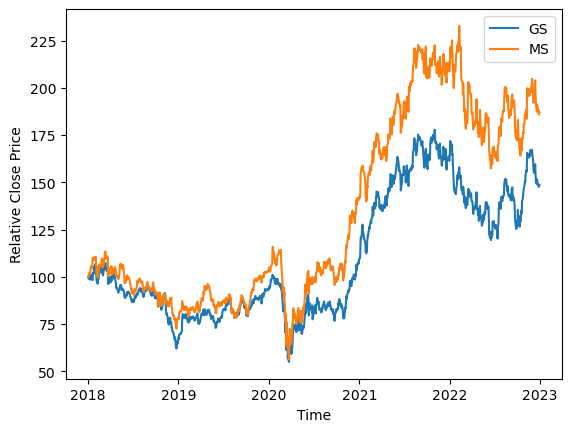

In [92]:
#Adjusting Time series

stock1_close_relative = stock1_data["Close"]/stock1_data["Close"][0] * 100.
stock2_close_relative = stock2_data["Close"]/stock2_data["Close"][0] * 100.
plt.plot(stock1_close_relative, label = 'GS') 
plt.plot(stock2_close_relative, label = 'MS')
plt.xlabel('Time')
plt.ylabel('Relative Close Price')
plt.legend()
plt.show()

In [93]:
#Regression Model

Y = np.log(stock2_data["Close"])
X = np.log(stock1_data["Close"])
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params

alpha = results.params.values[0]
beta = results.params.values[1]
errors = Y - (alpha + X["Close"]*beta)

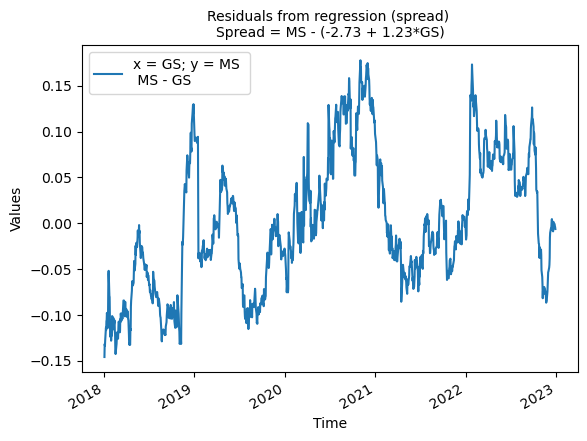

In [94]:
#Spread

errors.plot(label = f"x = {stock1_name}; y = {stock2_name} \n {stock2_name} - {stock1_name}")
plt.title(f"Residuals from regression (spread) \nSpread = {stock2_name} - ({alpha:.2f} + {beta:.2f}*{stock1_name})", fontsize=10) 
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

In [95]:
#Dickey Fuller Test

dftest = adfuller (errors, maxlag = 1)
dfoutput = pd.Series(dftest [0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used",],)
critical_values = pd.Series(dftest[4].values(), index = dftest[4].keys())
print(f"Dickey Fuller Result:\n{dfoutput} \n\n Dickey Fuller Critical Values: \n{critical_values}")

Dickey Fuller Result:
Test Statistic                   -3.135138
p-value                           0.024060
#Lags Used                        0.000000
Number of Observations Used    1258.000000
dtype: float64 

 Dickey Fuller Critical Values: 
1%    -3.435559
5%    -2.863840
10%   -2.567995
dtype: float64


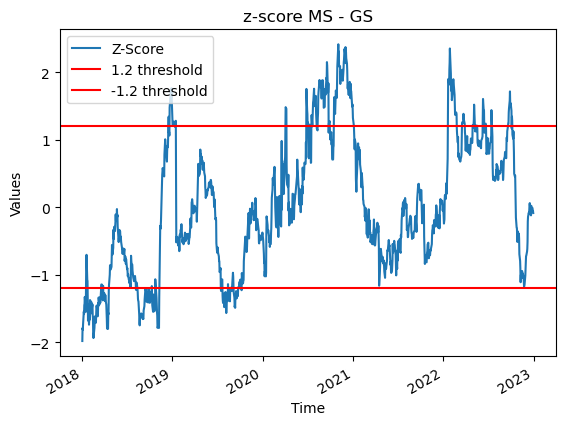

In [96]:
#Defining Z-Score

spread = errors
zscore = (spread - np.mean (spread)) / np.std(spread)
zscore.plot(label = "Z-Score")
plt.title(f"z-score {stock2_name} - {stock1_name}")
plt.xlabel("Time")
plt.ylabel("Values")
plt.axhline(y = 1.2, color = 'r', label = '1.2 threshold')
plt.axhline(y= -1.2, color = 'r', label='-1.2 threshold')
plt.legend()
plt.show()

In [97]:
#Long/Short Strategy

btest = pd.DataFrame()
btest["stock2"] = stock2_data["Close"]
btest["stock1"] = stock1_data["Close"]

btest["short signal"] = (zscore > 1.2) & (zscore.shift(1) < 1.2)
btest["short exit"] = (zscore < -1.2) & (zscore.shift(1) > -1.2)

btest["long signal"] = (zscore < -1.2) & (zscore.shift(1) > -1.2)
btest["long exit"] = (zscore > 1.2) & (zscore.shift(1) < 1.2)

In [98]:
# Backtest

spread_side = None; counter = -1
backtest_result = []; indicator = 0

for time, signals_stock in btest.iterrows():
    counter += 1
    stock2_, stock1_, short_signal, short_exit, long_signal, long_exit = signals_stock
    
    if spread_side == None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result.append([time, return_stock2, return_stock1, spread_side])
    
        if short_signal == True:
            spread_side = "short"
        elif long_signal == True:
            spread_side = "long"

    elif spread_side == "long":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][ counter -1] -1
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter -1] -1
        backtest_result.append([time, return_stock2, -return_stock1, spread_side])

        if long_exit == True:
            spread_side = None

    elif spread_side == "short":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][ counter -1] -1
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter -1] -1
        backtest_result.append([time, -return_stock2, return_stock1, spread_side])
    
        if short_exit == True:
            spread_side = None

In [99]:
#Transform into DataFrame

backtest_pandas = pd.DataFrame (backtest_result)
backtest_pandas.columns = ["Date","stock2", "stock1", "Side"]
backtest_pandas["Stock2 P&L"] = np.cumprod(backtest_pandas ["stock2"] + 1.)
backtest_pandas["Stock1 P&L"] = np.cumprod(backtest_pandas["stock1"] + 1.)
backtest_pandas ["Total P&L"] = (backtest_pandas["Stock1 P&L"] + backtest_pandas ["Stock2 P&L"])/2.
backtest_pandas.index = backtest_pandas["Date"]

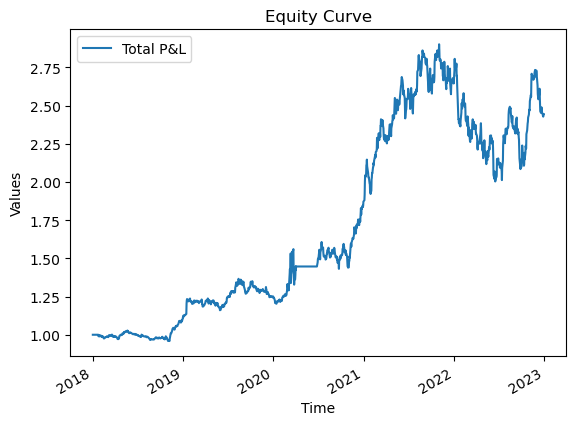

                           Total P&L
Date                                
2018-01-02 00:00:00-05:00   1.000000
2018-01-03 00:00:00-05:00   1.000000
2018-01-04 00:00:00-05:00   1.000000
2018-01-05 00:00:00-05:00   1.000000
2018-01-08 00:00:00-05:00   1.000000
...                              ...
2022-12-23 00:00:00-05:00   2.457899
2022-12-27 00:00:00-05:00   2.434709
2022-12-28 00:00:00-05:00   2.427801
2022-12-29 00:00:00-05:00   2.444518
2022-12-30 00:00:00-05:00   2.444407

[1259 rows x 1 columns]


In [101]:
# Plot Strategy Results

backtest_pandas[["Total P&L"]].plot(label = "Evolution P&L")
plt.title("Equity Curve")
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()
print(backtest_pandas[["Total P&L"]])

In [ ]:
# Credits: Edoardo Alberto Donolato